In [1]:
from pathlib import Path
import sys
sys.path.append('../bitome-kb/')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sparse
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.utils.class_weight import compute_class_weight
from bitome.core import Bitome
from math import log,exp,inf
bitome = Bitome.init_from_file('../bitome-kb/bitome.pkl')

from Bio.SeqFeature import FeatureLocation
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
from Bio.Seq import Seq

In [2]:
import ast
im_info = pd.read_csv('data/precise2_im_info_new.csv')
IM_genes = {}
for i in range(len(im_info['im_name'])):
    IM_genes[im_info['im_name'][i]] = ast.literal_eval( im_info['genes'][i] )

avg_features = pd.read_csv('features_avg.csv')

In [3]:
b_g = {}
for g in bitome.genes:
    b_g[g.locus_tag] = g.name

# ArcA case (2DR, 3DR, 4DR, 5DR)
#### ref:https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3798270/


### find DR, and binary result 0 or 1.

In [4]:
import logomaker as lm
import Bio.motifs as motifs

In [5]:
ArcA_2DR = []
ArcA_3DR = []
ArcA_4DR = []

ArcA_DR = []
ffile = open('data/ArcA_DR.txt', "rt")
lines = ffile.readlines()
ffile.close()
for line in lines:
    if line[0] == '>':
        continue
    seq = line.strip()
    if len(seq) >40:
        ArcA_DR.append( seq[0:10])
        ArcA_DR.append( seq[11:21])
        ArcA_DR.append( seq[22:32])
        ArcA_DR.append( seq[33:43])
        ArcA_4DR.append( seq)
    elif len(seq) > 30:
        ArcA_DR.append( seq[0:10])
        ArcA_DR.append( seq[11:21])
        ArcA_DR.append( seq[22:32])
        ArcA_3DR.append( seq )
    else:
        ArcA_DR.append( seq[0:10])
        ArcA_DR.append( seq[11:21])
        ArcA_2DR.append( seq )
        ArcA_2DR = list(filter(lambda a: len(a) != 0, ArcA_2DR))
        
ArcA_DR = list(filter(lambda a: len(a) == 10, ArcA_DR))

In [6]:
counts_mat = lm.alignment_to_matrix(ArcA_DR)

In [7]:
M_DR = []
for i in range(len(counts_mat['A']) ):
    SUM = 4+ counts_mat['A'][i]+counts_mat['C'][i]+counts_mat['T'][i]+counts_mat['G'][i]
    
    M_DR.append( {'A':log( (counts_mat['A'][i]+1)/SUM ),
                  'C':log( (counts_mat['C'][i]+1)/SUM ),
                  'G':log( (counts_mat['G'][i]+1)/SUM ),
                  'T':log( (counts_mat['T'][i]+1)/SUM  )   })

findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


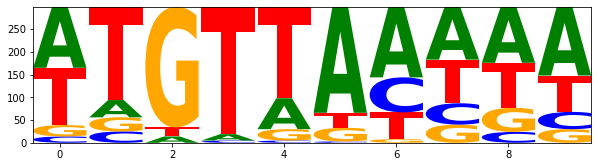

In [8]:
lm.Logo(counts_mat)

In [9]:
cm = {2:lm.alignment_to_matrix(ArcA_2DR),3:lm.alignment_to_matrix(ArcA_3DR),4:lm.alignment_to_matrix(ArcA_4DR)}

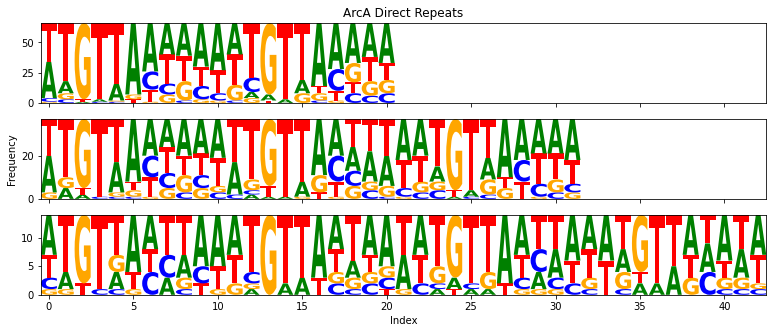

In [11]:
fig, axs = plt.subplots(3,1,figsize=(13,5),sharex=True)
for i in [2,3,4]:
    lm.Logo( cm[i], ax = axs[i-2])
axs[1].set_ylabel('Frequency')
axs[2].set_xlabel('Index')
axs[0].set_title('ArcA Direct Repeats')
fig.savefig('../../thesis_plots/ArcA_DRmotif.svg',dpi=150)

In [12]:
PWM_DR = {}
for k in cm.keys():
    temp_pwm = []
    temp_cm = cm[k]
    for i in range(len(temp_cm['A']) ):
        SUM = 4+ temp_cm['A'][i]+temp_cm['C'][i]+temp_cm['T'][i]+temp_cm['G'][i]

        temp_pwm.append( {'A':log( (temp_cm['A'][i]+1)/SUM ),
                      'C':log( (temp_cm['C'][i]+1)/SUM ),
                      'G':log( (temp_cm['G'][i]+1)/SUM ),
                      'T':log( (temp_cm['T'][i]+1)/SUM  )   })
    PWM_DR[k] = temp_pwm

PWM_DR[1] = M_DR

In [13]:
no_signal = { 'A':log(0.25) , 'C':log(0.25) ,'G':log(0.25), 'T':log(0.25)}
PWM_DR_avg = {}
for k in PWM_DR.keys():
    PWM_DR_avg[k] =  M_DR.copy()
    for i in range( int(k-1)):
        PWM_DR_avg[k].append( no_signal )
        PWM_DR_avg[k] =  PWM_DR_avg[k] +  M_DR       

# # remember to log probability

In [14]:
from feature_functions import *
N_UPSTREAM  = 150
N_DOWNSTREAM = 30

In [14]:
def DR_match( tss, strand , bitome_obj, N_UPSTREAM, N_DOWNSTREAM, M, N ):
    # N is the number of DRs to match
    if strand == 1:
        
        locs = np.arange(tss - N_UPSTREAM, tss + N_DOWNSTREAM + 1)
        bp_to_tss = np.arange(-N_UPSTREAM, N_DOWNSTREAM + 1)
        
        # define the sequence feature location to extract the sequence around this TSS
        seq_loc = FeatureLocation(
            tss - N_UPSTREAM - 1,
            tss + N_DOWNSTREAM,
            strand
        )
        
    else:

        locs = np.arange(tss - N_DOWNSTREAM, tss + N_UPSTREAM + 1)
        bp_to_tss = np.flip(np.arange(-N_UPSTREAM, N_DOWNSTREAM + 1))

        # define the sequence feature location to extract the sequence around this TSS
        seq_loc = FeatureLocation(
            tss - N_DOWNSTREAM - 1,
            tss + N_UPSTREAM,
            strand
        )
    sequence = seq_loc.extract(bitome_obj.sequence)
    ind_avoid = []
    DR_scores_top = []
    for j in range(N):
        DR_scores = []
        for i in range(len(sequence) - len(M) + 1):
            if i not in ind_avoid:
                subbox = sequence[i:i+10]
                DR_scores.append( (score_motif(subbox,M),  i ) )# store tuple( score,index )
        
        sorted(DR_scores, key=lambda tup: tup[0],reverse=True) # select max scores
        DR_scores_top.append( DR_scores[0] )
        # ensure at least 11bp spacing
        temp_ind = DR_scores[0][1]
        ind_avoid = ind_avoid + list( np.arange(temp_ind,temp_ind+len(M) + 1,1 ) )
        if temp_ind > len(M):
            ind_avoid = ind_avoid + list( np.arange(temp_ind - 10 ,temp_ind,1 ) )
        else:
            ind_avoid = ind_avoid + list( np.arange(0,temp_ind,1 ) )
            
    
    DR_data = []
    for score,ind in DR_scores_top:
        left = ind
        right = ind + len(M)
        mid = (left+right)/2
        if mid < N_UPSTREAM:
            up = 1
        else:
            up = 0
        distTSS = abs(N_UPSTREAM - mid )
        DR_data.append( (score,up,distTSS,ind) )
    sorted( DR_data, key=lambda tup: tup[3],reverse=False)
    result = {}
    
    for k in range(len(DR_data)):
        result.update({'DR_'+str(k+1)+'_score':DR_data[k][0], 'DR_'+str(k+1)+'_upTSS':DR_data[k][1],
                      'DR_'+str(k+1)+'_distTSS':DR_data[k][2] })
        if k != 0:
            result['DR_'+str(k)+str(k+1)] = abs( DR_data[k][3] - DR_data[k-1][3] )
  
    return result

In [15]:
N_DR = 5
ArcA_data = []
for g in bitome.genes:
    if len(g.transcription_units) < 1:
        continue
    
    for tu in g.transcription_units:
        if tu.tss == None or int(tu.tss) < 200:
            continue
        data = {}
        data = {}
        data['ID'] = g.locus_tag
        data['gene'] = g.name
        data['TU'] = tu.name
        data['strand'] = int(tu.location.strand)
        data.update( DR_match( tu.tss ,  int(tu.location.strand) , bitome , N_UPSTREAM, N_DOWNSTREAM, M_DR, N_DR ) )
        ArcA_data.append(data)

In [16]:
DR_table = pd.DataFrame( ArcA_data )

In [17]:
DR_table

,ID,gene,TU,strand,DR_1_score,DR_1_upTSS,DR_1_distTSS,DR_2_score,DR_2_upTSS,DR_2_distTSS,...,DR_3_distTSS,DR_23,DR_4_score,DR_4_upTSS,DR_4_distTSS,DR_34,DR_5_score,DR_5_upTSS,DR_5_distTSS,DR_45
0,b0008,talB,talB,1,-14.780241,1,145.0,-21.656315,1,134.0,...,123.0,11,-14.456473,1,112.0,11,-23.531274,1,101.0,11
1,b0014,dnaK,dnaK-tpke11-dnaJ,1,-18.750339,1,145.0,-15.376458,1,134.0,...,123.0,11,-20.210180,1,112.0,11,-18.075302,1,101.0,11
2,b0014,dnaK,dnaK-tpke11-dnaJ,1,-18.730273,1,145.0,-19.742781,1,134.0,...,123.0,11,-23.793180,1,112.0,11,-17.195534,1,101.0,11
3,b0014,dnaK,dnaK-tpke11-dnaJ,1,-17.609550,1,145.0,-22.246534,1,134.0,...,123.0,11,-18.641690,1,112.0,11,-17.396075,1,101.0,11
4,b0015,dnaJ,dnaK-tpke11-dnaJ,1,-18.750339,1,145.0,-15.376458,1,134.0,...,123.0,11,-20.210180,1,112.0,11,-18.075302,1,101.0,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4022,b4401,arcA,arcA,-1,-20.691225,1,145.0,-12.660784,1,134.0,...,123.0,11,-17.341367,1,112.0,11,-19.800956,1,101.0,11
4023,b4401,arcA,arcA,-1,-11.086996,1,145.0,-12.357568,1,134.0,...,123.0,11,-15.699910,1,112.0,11,-14.593752,1,101.0,11
4024,b4401,arcA,arcA,-1,-17.874799,1,145.0,-14.624736,1,134.0,...,123.0,11,-20.235956,1,112.0,11,-25.721849,1,101.0,11
4025,b4401,arcA,arcA,-1,-17.715303,1,145.0,-15.798184,1,134.0,...,123.0,11,-26.689100,1,112.0,11,-14.028838,1,101.0,11


In [18]:
tf_list =['AraC', 'ArcA', 'ArgP', 'ArgR', 'BaeR', 'BasR', 'CysB', 'CpxR', 
          'Cra', 'CRP', 'Mlc', 'MqsA', 'EvgA', 'ExuR', 'FadR', 'IclR', 'IscR', 
          'IHF', 'FhlA', 'FlhDC', 'FNR', 'Fur', 'GadE', 'GadW', 'GadX', 'GalR', 'GalS', 
          'GcvA', 'GlpR', 'GlrR', 'GntR', 'TyrR', 'LexA', 'LeuO', 'Lrp', 'MalT', 'MetJ', 'Nac', 
          'NagC', 'NanR', 'NarL', 'NarP', 'NrdR', 'NsrR', 'NtrC', 'OmpR', 'OxyR', 'PdhR', 'PhoB', 'PhoP',
          'PurR', 'PuuR', 'RcsAB', 'RhaS', 'RutR', 'SoxS', 'TrpR', 'XylR', 'YdeO']
regulon_genes={}
for TF in bitome.transcription_factors:
    if TF.name in tf_list:
        regulon_genes[TF.name] = []   
        for r in TF.regulons:
                for p in list(r.regulated_promoters.values())[0]:
                    if p.transcription_unit != None and len(p.transcription_unit.genes)>0:
                        for g in p.transcription_unit.genes:
                            regulon_genes[TF.name].append( g.name)

In [19]:
DR12 = []
DR23 = []
DR34 = []
DR45 = []
for i in range(len( DR_table['gene'])):
    if list(DR_table['gene'])[i] in regulon_genes['ArcA']:
        DR12.append( list( DR_table['DR_12'])[i] )
        DR23.append( list( DR_table['DR_23'])[i] )
        DR34.append( list( DR_table['DR_34'])[i] )
        DR45.append( list( DR_table['DR_45'])[i] )

In [20]:
DR_1_score = []
DR_2_score = []
DR_3_score = []
DR_4_score = []
DR_5_score = []
for i in range(len( DR_table['gene'])):
    if list(DR_table['gene'])[i] in regulon_genes['ArcA']:
        DR_1_score.append( list( DR_table['DR_1_score'])[i] )
        DR_2_score.append( list( DR_table['DR_2_score'])[i] )
        DR_3_score.append( list( DR_table['DR_3_score'])[i] )
        DR_4_score.append( list( DR_table['DR_4_score'])[i] )
        DR_5_score.append( list( DR_table['DR_5_score'])[i] )

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


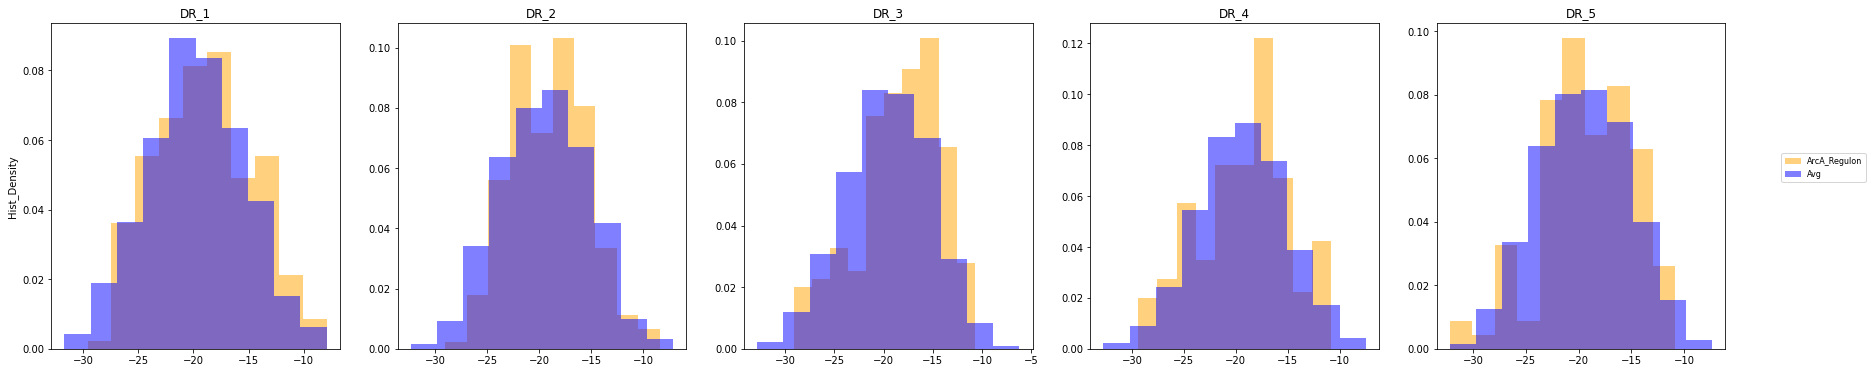

In [21]:
fig,axs = plt.subplots(1,5, figsize = (30,6))
axs[0].hist(DR_1_score,density=True, alpha=0.5,color ='orange')
axs[0].hist(list( DR_table['DR_1_score']),density=True, alpha=0.5,color ='b')
axs[0].set_ylabel('Hist_Density')

axs[1].hist(DR_2_score,density=True, alpha=0.5,color ='orange')
axs[1].hist(list( DR_table['DR_2_score']),density=True, alpha=0.5,color ='b')
axs[2].hist(DR_3_score,density=True, alpha=0.5,color ='orange')
axs[2].hist(list( DR_table['DR_3_score']),density=True, alpha=0.5,color ='b')
axs[3].hist(DR_4_score,density=True, alpha=0.5,color ='orange')
axs[3].hist(list( DR_table['DR_4_score']),density=True, alpha=0.5,color ='b')
axs[4].hist(DR_5_score,density=True, alpha=0.5,color ='orange',label = 'ArcA_Regulon')
axs[4].hist(list( DR_table['DR_5_score']),density=True, alpha=0.5,color ='b',label='Avg')
axs[4].legend(loc='lower right', fontsize=8, bbox_to_anchor=(1.5, 0.5))

for i in range(5):
    axs[i].set_title('DR_'+str(i+1))

# visualize DR on ArcA genes

In [15]:
def match1DR( tss, strand , bitome_obj, N_UPSTREAM, N_DOWNSTREAM, M, DR_num, cutoff ):
     # N is the number of DRs to match
    if strand == 1:
        
        locs = np.arange(tss - N_UPSTREAM, tss + N_DOWNSTREAM + 1)
        bp_to_tss = np.arange(-N_UPSTREAM, N_DOWNSTREAM + 1)
        
        # define the sequence feature location to extract the sequence around this TSS
        seq_loc = FeatureLocation(
            tss - N_UPSTREAM - 1,
            tss + N_DOWNSTREAM,
            strand
        )
        
    else:

        locs = np.arange(tss - N_DOWNSTREAM, tss + N_UPSTREAM + 1)
        bp_to_tss = np.flip(np.arange(-N_UPSTREAM, N_DOWNSTREAM + 1))

        # define the sequence feature location to extract the sequence around this TSS
        seq_loc = FeatureLocation(
            tss - N_DOWNSTREAM - 1,
            tss + N_UPSTREAM,
            strand
        )
    DR_scores = []
    sequence = seq_loc.extract(bitome_obj.sequence)
    for i in range(len(sequence) - len(M) + 1):
        subbox = sequence[i:i+ len(M) ]
        DR_scores.append( score_motif(subbox,M) )# store tuple( score,index )
        
    max_score =  max( DR_scores )
    ind = DR_scores.index( max_score )
    mid = ind + len(M)/2  
    distTSS = abs(N_UPSTREAM - mid )
    if mid < N_UPSTREAM:
        up = 1
    else:
        up = 0
    result = {}
    result[str(DR_num)+'DR_score'] = max_score
    result[str(DR_num)+'DR_distTSS'] = distTSS
    result[str(DR_num)+'DR_upstream'] = up
    result['seq'] = str(sequence)
    
    if max_score > cutoff[DR_num ]:
        result[ str(DR_num)+'DR_abovecutoff' ] = 1
    else:
        result[ str(DR_num)+'DR_abovecutoff' ] = 0
        
    return result

In [16]:
# regulons
pwm_db = rpwm('data/motif_pwm_db.txt')

tf_list =['AraC', 'ArcA', 'ArgP', 'ArgR', 'BaeR', 'BasR', 'CysB', 'CpxR', 
          'Cra', 'CRP', 'Mlc', 'MqsA', 'EvgA', 'ExuR', 'FadR', 'IclR', 'IscR', 
          'IHF', 'FhlA', 'FlhDC', 'FNR', 'Fur', 'GadE', 'GadW', 'GadX', 'GalR', 'GalS', 
          'GcvA', 'GlpR', 'GlrR', 'GntR', 'TyrR', 'LexA', 'LeuO', 'Lrp', 'MalT', 'MetJ', 'Nac', 
          'NagC', 'NanR', 'NarL', 'NarP', 'NrdR', 'NsrR', 'NtrC', 'OmpR', 'OxyR', 'PdhR', 'PhoB', 'PhoP',
          'PurR', 'PuuR', 'RcsAB', 'RhaS', 'RutR', 'SoxS', 'TrpR', 'XylR', 'YdeO']

regulon_genes={}
for TF in bitome.transcription_factors:
    if TF.name in tf_list:
        regulon_genes[TF.name] = []   
        for r in TF.regulons:
                for p in list(r.regulated_promoters.values())[0]:
                    if p.transcription_unit != None and len(p.transcription_unit.genes)>0:
                        for g in p.transcription_unit.genes:
                            regulon_genes[TF.name].append(   g.locus_tag )
# cobvert gene name and b number.
b_g = {}
for g in bitome.genes:
    b_g[ g.locus_tag ] = g.name

In [17]:
ArcA_IM_reg = set(regulon_genes['ArcA']) & set(IM_genes['ArcA'])
print(ArcA_IM_reg)

{'b0733', 'b0312', 'b0721', 'b1298', 'b0720', 'b0904', 'b1297', 'b1612', 'b0313', 'b3846', 'b3603', 'b0314'}


In [18]:
# cutoff values
cutoff = { 1: -8.4 ,2: -23.3628,3: -38.44,4:-52.94}

In [19]:
N_UPSTREAM  = 150
N_DOWNSTREAM = 30
ArcA_IM_reg_DR = []
for bnumber in ArcA_IM_reg:
    gene = bitome.get_gene( b_g[bnumber] )
    strand = int(gene.location.strand)
    if len(gene.transcription_units) < 1:
        continue
        
    for tu in gene.transcription_units:
        if tu.tss == None:
            continue
        
        tss = tu.tss
        data = {}
        data['ID'] = gene.locus_tag
        data['gene'] = gene.name
        data['TU'] = tu.name
        data['strand'] = int(tu.location.strand)
        for k in PWM_DR_avg.keys():
            data.update(  match1DR( tu.tss ,  int(tu.location.strand) , bitome ,
                                   N_UPSTREAM, N_DOWNSTREAM, PWM_DR_avg[k], int(k),cutoff ) )
            
        ArcA_IM_reg_DR.append(data)

In [20]:
ArcA_IM_reg_DR_pd = pd.DataFrame( ArcA_IM_reg_DR)
ArcA_IM_reg_DR_pd.head()

,ID,gene,TU,strand,2DR_score,2DR_distTSS,2DR_upstream,seq,2DR_abovecutoff,3DR_score,...,3DR_upstream,3DR_abovecutoff,4DR_score,4DR_distTSS,4DR_upstream,4DR_abovecutoff,1DR_score,1DR_distTSS,1DR_upstream,1DR_abovecutoff
0,b0733,cydA,cydAB,1,-22.568068,122.5,1,AAACATAAATGTCACTAAAGTTACCTTATTGAAACATGATTAACAT...,1,-37.626786,...,1,1,-50.593812,103.5,1,1,-9.355523,128.0,1,0
1,b0733,cydA,cydAB,1,-22.568068,133.5,1,TCACTAAAGTTACCTTATTGAAACATGATTAACATAATTTGTAGGA...,1,-37.626786,...,1,1,-50.593812,114.5,1,1,-9.355523,139.0,1,0
2,b0733,cydA,cydAB,1,-21.326986,57.5,1,CGAAAAATGCAAATTTGCTTCAACAAAAACCTGTTTATTGTAAGGA...,1,-40.660786,...,1,0,-56.109294,46.5,1,0,-9.005581,63.0,1,0
3,b0733,cydA,cydAB,1,-22.568068,90.5,1,AACTAATTTCAGCCTTATAACTCACACATTTTAAACATAAATGTCA...,1,-37.626786,...,1,1,-50.593812,71.5,1,1,-9.355523,96.0,1,0
4,b0733,cydA,cydAB,1,-24.486090,18.5,0,TTGGAAATGGGCATCAAAAAGAGATAAATTGTTCTCGATCAAATTG...,0,-41.643868,...,1,0,-58.050624,8.5,0,0,-9.005581,21.0,0,0


In [20]:
from dna_features_viewer import GraphicFeature, GraphicRecord

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


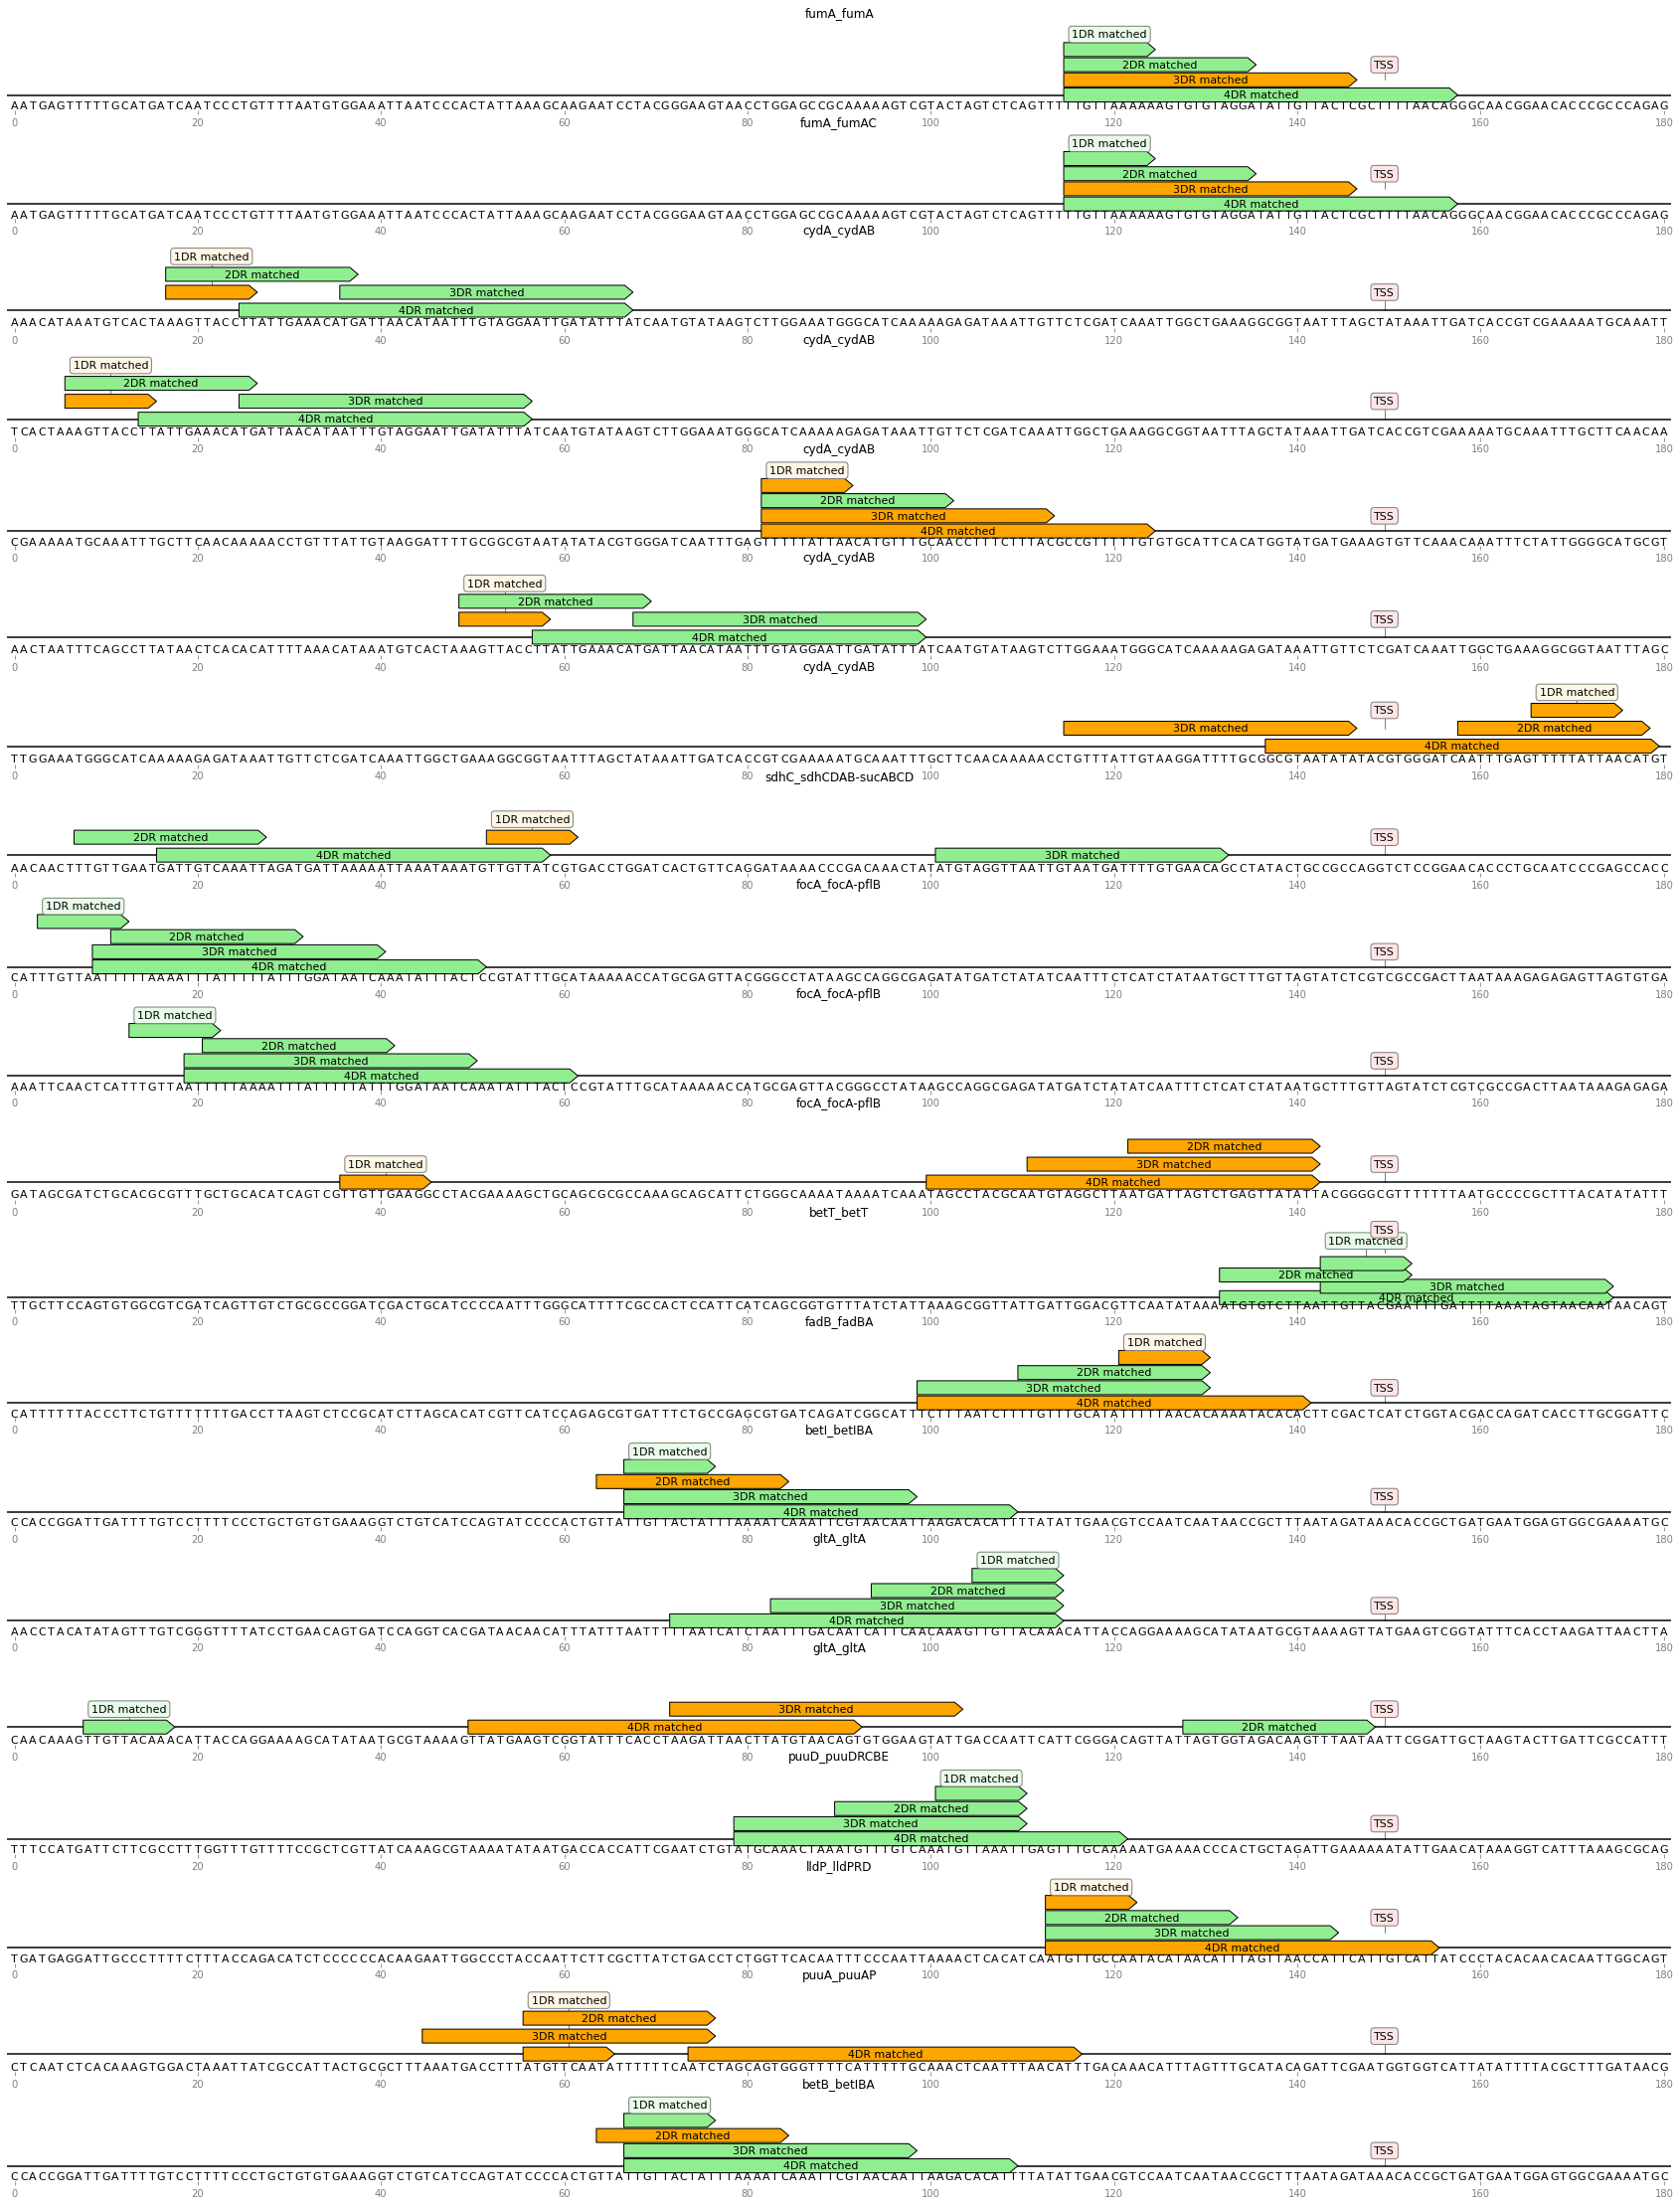

In [29]:
colors =['lightgreen', 'orange']

fig, axs = plt.subplots( len(ArcA_IM_reg_DR), 1, figsize = (30,40) )
for i in range( len(ArcA_IM_reg_DR) ):
    temp_seq = ArcA_IM_reg_DR_pd['seq'][i]
    gname = ArcA_IM_reg_DR_pd['gene'][i]
    tu_name = ArcA_IM_reg_DR_pd['TU'][i]
    features = [ GraphicFeature(start= 150, end=150, strand=+1, color='red',label="TSS") ]
    for k in PWM_DR.keys():
        distTSS = ArcA_IM_reg_DR_pd[ str(k)+'DR_distTSS'][i]
        
        if ArcA_IM_reg_DR_pd[ str(k)+'DR_abovecutoff'][i] == 1:
            temp_color = colors[0]
        else:
            temp_color = colors[1]
        
        if ArcA_IM_reg_DR_pd[str(k)+'DR_upstream'][i] == 1:
            mid = 150 - distTSS
        else:
            mid = 150 + distTSS
        width = len(PWM_DR[k])
        features.append(  GraphicFeature(start= mid-width/2 , end=mid+width/2, strand=+1,
                                         color=temp_color,label = str(k)+"DR matched") )
    
    
    
    record = GraphicRecord(sequence_length= 181 , sequence= temp_seq , features=features )
    record.plot(figure_width=5, ax = axs[i])
    record.plot_sequence(ax = axs[i])
    axs[i].set_title( gname + '_' + tu_name, pad = 0.05 )

In [21]:
ArcA_data = []
for g in bitome.genes:
    if len(g.transcription_units) < 1:
        continue
    
    for tu in g.transcription_units:
        if tu.tss == None or int(tu.tss) < 200:
            continue
        data = {}
        data = {}
        data['ID'] = g.locus_tag
        data['gene'] = g.name
        data['TU'] = tu.name
        data['strand'] = int(tu.location.strand)
        for k in PWM_DR.keys():
            data.update(  match1DR( tu.tss ,  int(tu.location.strand) , bitome ,
                                   N_UPSTREAM, N_DOWNSTREAM, PWM_DR[k], int(k),cutoff ) )
        ArcA_data.append(data)

In [22]:
DR_table = pd.DataFrame( ArcA_data )

In [23]:
DR_table.head()

,ID,gene,TU,strand,2DR_score,2DR_distTSS,2DR_upstream,seq,2DR_abovecutoff,3DR_score,...,3DR_upstream,3DR_abovecutoff,4DR_score,4DR_distTSS,4DR_upstream,4DR_abovecutoff,1DR_score,1DR_distTSS,1DR_upstream,1DR_abovecutoff
0,b0008,talB,talB,1,-26.782829,135.5,1,TACTTGATAACTTCTGCGTAGCATACATGAGGTTTTGTATAAAAAT...,0,-42.126282,...,1,0,-58.358297,124.5,1,0,-8.326755,111.0,1,1
1,b0014,dnaK,dnaK-tpke11-dnaJ,1,-28.650483,99.5,1,ATGCCTTGGCTGCGATTCATTCTTTATATGAATAAAATTGCTGTCA...,0,-42.941733,...,1,0,-55.850708,110.5,1,0,-10.375626,120.0,1,0
2,b0014,dnaK,dnaK-tpke11-dnaJ,1,-29.099274,13.5,1,AATTTCTGCGCAAAAGCACAAAAAATTTTTGCATCTCCCCCTTGAT...,0,-45.489964,...,1,0,-58.703340,48.5,1,0,-10.837004,95.0,1,0
3,b0014,dnaK,dnaK-tpke11-dnaJ,1,-28.199748,10.5,0,AAAATTTTTGCATCTCCCCCTTGATGACGTGGTTTACGACCCCATT...,0,-45.489964,...,1,0,-58.703340,69.5,1,0,-10.061136,26.0,0,0
4,b0015,dnaJ,dnaK-tpke11-dnaJ,1,-28.650483,99.5,1,ATGCCTTGGCTGCGATTCATTCTTTATATGAATAAAATTGCTGTCA...,0,-42.941733,...,1,0,-55.850708,110.5,1,0,-10.375626,120.0,1,0


In [24]:
DR1score = []
DR2score = []
DR3score = []
DR4score = []
for i in range(len( DR_table['gene'])):
    if list(DR_table['ID'])[i] in regulon_genes['ArcA']:
        DR1score.append( list( DR_table['1DR_score'])[i] )
        DR2score.append( list( DR_table['2DR_score'])[i] )
        DR3score.append( list( DR_table['3DR_score'])[i] )
        DR4score.append( list( DR_table['4DR_score'])[i] )

In [22]:
from scipy import stats

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


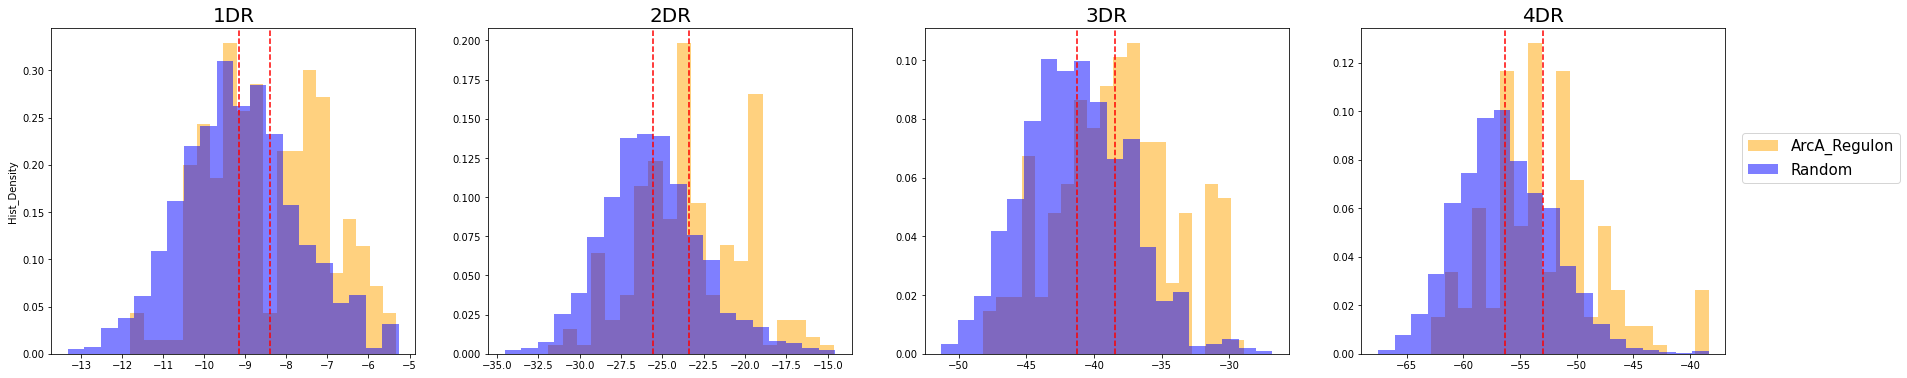

In [23]:
fig,axs = plt.subplots(1,4, figsize = (30,6))

axs[0].hist(DR1score,density=True,bins=20, alpha=0.5,color ='orange')
axs[0].hist(list( DR_table['1DR_score']),density=True,bins=20, alpha=0.5,color ='b')
axs[0].axvline( x= sum(DR_table['1DR_score'])/len(DR_table['1DR_score']), color = 'r', ls = '--')
axs[0].axvline( x= sum(DR1score)/len(DR1score), color = 'r', ls = '--')
axs[0].set_ylabel('Hist_Density')

axs[1].hist(DR2score,density=True, bins=20, alpha=0.5,color ='orange')
axs[1].hist(list( DR_table['2DR_score']),density=True,bins=20, alpha=0.5,color ='b')
axs[1].axvline( x= sum(DR_table['2DR_score'])/len(DR_table['2DR_score']), color = 'r', ls = '--')
axs[1].axvline( x= sum(DR2score)/len(DR2score), color = 'r', ls = '--')

axs[2].hist(DR3score,density=True, bins=20, alpha=0.5,color ='orange')
axs[2].hist(list( DR_table['3DR_score']),density=True,bins=20, alpha=0.5,color ='b')
axs[2].axvline( x= sum(DR_table['3DR_score'])/len(DR_table['3DR_score']), color = 'r', ls = '--')
axs[2].axvline( x= sum(DR3score)/len(DR3score), color = 'r', ls = '--')

axs[3].hist(DR4score,density=True,bins=20,  alpha=0.5,color ='orange',label = 'ArcA_Regulon')
axs[3].hist(list( DR_table['4DR_score']),density=True, bins=20, alpha=0.5,color ='b',label = 'Random')
axs[3].axvline( x= sum(DR_table['4DR_score'])/len(DR_table['4DR_score']), color = 'r', ls = '--')
axs[3].axvline( x= sum(DR4score)/len(DR4score), color = 'r', ls = '--')
axs[3].legend(loc='lower right', fontsize=15, bbox_to_anchor=(1.5, 0.5))

for i in range(4):
    axs[i].set_title(str(i+1)+'DR',fontsize = 20)

## look for cutoff 

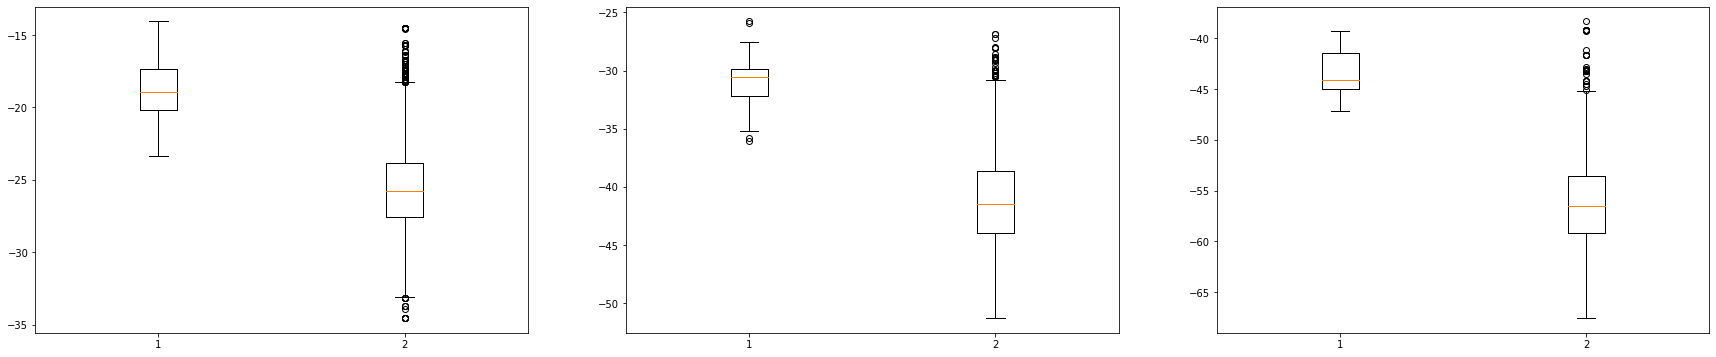

In [24]:
seq_scores = {2:[],3:[],4:[]}
for seq in ArcA_2DR:
    seq_scores[2].append( score_motif(seq,PWM_DR_avg[2]) )
for seq in ArcA_3DR:
    seq_scores[3].append( score_motif(seq,PWM_DR_avg[3]) )
for seq in ArcA_4DR:
    seq_scores[4].append( score_motif(seq,PWM_DR_avg[4]) )
    
fig,axs = plt.subplots(1,3, figsize = (30,6))
for i in range(3):
    axs[i].boxplot( [seq_scores[i+2], list( DR_table[str(i+2)+'DR_score']) ])

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


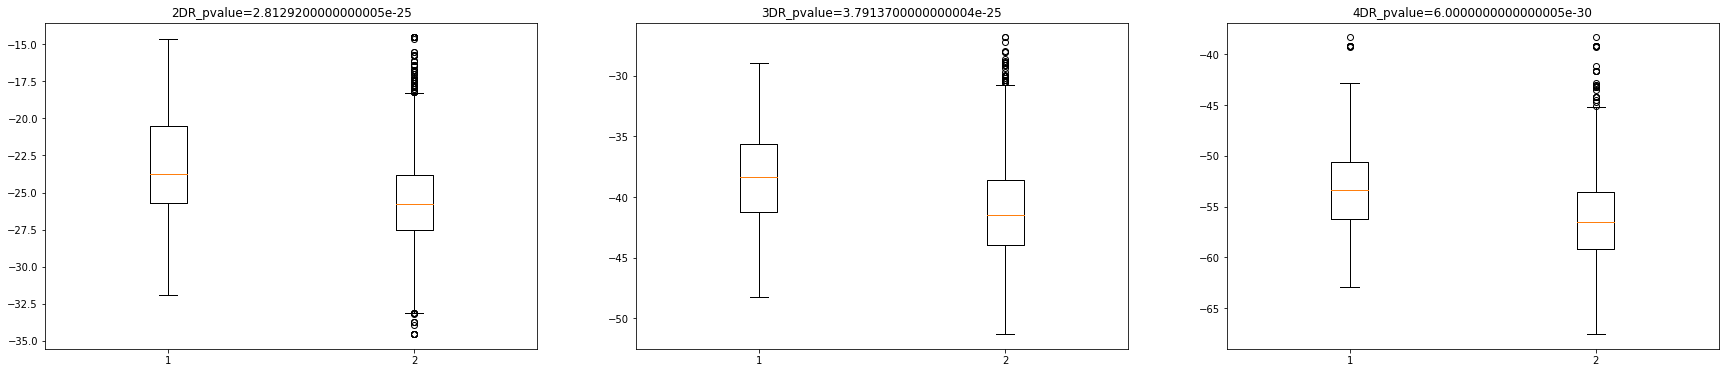

In [25]:
temp_data = [DR2score, DR3score, DR4score]
fig,axs = plt.subplots(1,3, figsize = (30,6))
for i in range(3):
    axs[i].boxplot( [ temp_data[i], list( DR_table[str(i+2)+'DR_score']) ])
    pvalue = stats.ttest_ind(temp_data[i],list( DR_table[str(i+2)+'DR_score']) ).pvalue
    pvalue = round(pvalue,30)
    axs[i].set_title(str(i+2)+'DR_'+'pvalue='+str(pvalue))

## try prediction using DR scores

In [25]:
temp_DR = DR_table.drop(['seq'],axis=1)

In [26]:
unique_ids = np.unique(list(temp_DR['ID']))

multiple_ids = {}
for n in unique_ids:
    if list(temp_DR['ID']).count(n) > 1:
        multiple_ids[n] = list(temp_DR['ID']).count(n)

remove_list = []
length = len(temp_DR['ID'])
for i in range(length):
    if temp_DR.iloc[i,0] in multiple_ids.keys():
        remove_list.append(i)

single_DR = temp_DR.drop(remove_list)
single_DR = single_DR.reset_index()
single_DR = single_DR.drop(columns=['index'])
single_DR= single_DR[['ID']+list(single_DR.columns)[3:]]

featureList = list(single_DR.columns)[1:]
multi = {}
for g in multiple_ids.keys():
    multi[g] = {}
    multi[g]['ID'] = str(g)
    for f in featureList:
        multi[g][f] = 0
        
for i in range(len(temp_DR['ID']) ):
    if temp_DR['ID'][i] in multiple_ids.keys():
        for f in featureList:
            multi[ str(temp_DR['ID'][i]) ][f] += float(temp_DR[f][i]/multiple_ids[str(temp_DR['ID'][i])])
            
multi_table = []
for k in multi.keys():
    multi_table.append(multi[k])
multi_pd = pd.DataFrame(multi_table)

avg_DR = single_DR.append(multi_pd)
avg_DR=avg_DR.reset_index()
avg_DR=avg_DR.drop(columns=['index'])
avg_DR.head()

,ID,strand,2DR_score,2DR_distTSS,2DR_upstream,2DR_abovecutoff,3DR_score,3DR_distTSS,3DR_upstream,3DR_abovecutoff,4DR_score,4DR_distTSS,4DR_upstream,4DR_abovecutoff,1DR_score,1DR_distTSS,1DR_upstream,1DR_abovecutoff
0,b0008,1.0,-26.782829,135.5,1.0,0.0,-42.126282,130.0,1.0,0.0,-58.358297,124.5,1.0,0.0,-8.326755,111.0,1.0,1.0
1,b0025,1.0,-28.706138,12.5,0.0,0.0,-45.930994,66.0,1.0,0.0,-58.313623,60.5,1.0,0.0,-10.507677,144.0,1.0,0.0
2,b0034,1.0,-26.100094,6.5,0.0,0.0,-39.136347,12.0,0.0,0.0,-54.037956,79.5,1.0,0.0,-8.097136,26.0,0.0,1.0
3,b0035,-1.0,-24.149415,89.5,1.0,0.0,-38.932659,133.0,1.0,0.0,-56.369400,127.5,1.0,0.0,-7.250062,133.0,1.0,1.0
4,b0036,-1.0,-24.149415,89.5,1.0,0.0,-38.932659,133.0,1.0,0.0,-56.369400,127.5,1.0,0.0,-7.250062,133.0,1.0,1.0


In [28]:
X_DR = avg_DR.iloc[:,1:].values
X_DR = StandardScaler().fit_transform(X_DR)
ID = list(avg_DR['ID'])
# generate labels, classify im membership
target_labels={}
for r in IM_genes.keys():
    target_labels[r] = []
    for i in range( len(ID) ):
        if ID[i] in IM_genes[r]:
            target_labels[r].append( 1 )
        else:
            target_labels[r].append( 0 )
            
ArcA_reg_lab = []
for i in range( len(ID) ):
    if ID[i] in regulon_genes['ArcA']:
        ArcA_reg_lab.append( 1 )
    else:
        ArcA_reg_lab.append( 0 )

In [29]:
y_to_try = {
    'ArcA':target_labels['ArcA'],
    'ArcA_regulon':ArcA_reg_lab
}
models_to_try = {
    'LR': LogisticRegression(
        penalty='l1',
        solver='saga',
        class_weight='balanced',
        random_state=42
    ),
    'SVM': LinearSVC(
        penalty='l1',
        class_weight='balanced',
        dual=False,
        random_state=42,
        verbose=1
    ),
    'RF': RandomForestClassifier(
        class_weight='balanced',
        random_state=42,
        verbose=1
    )
}

In [30]:
result_df = pd.DataFrame(
    columns=['model', 'im', 'train_auc', 'test_auc']
)

N_CV = 5

for model_name, model in models_to_try.items():
    print(f'{model_name}')
    
    for y_name, y_labels in y_to_try.items():
        print(f'{model_name}: {y_name}')
        
        cv_result = cross_validate(
            model,
            X_DR,
            y= y_labels,
            cv=N_CV,
            scoring='roc_auc',
            return_train_score=True,
            verbose=1,
            n_jobs=4
        )

        sub_result_df = pd.DataFrame(
            data={
                'model': [model_name] * N_CV,
                'im': [y_name] * N_CV,
                'train_auc': cv_result['train_score'],
                'test_auc': cv_result['test_score']
            }
        )

        result_df = result_df.append(sub_result_df)

LR
LR: ArcA


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


LR: ArcA_regulon


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


SVM
SVM: ArcA


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.2s finished


SVM: ArcA_regulon
RF
RF: ArcA


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: ArcA_regulon


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.0s finished


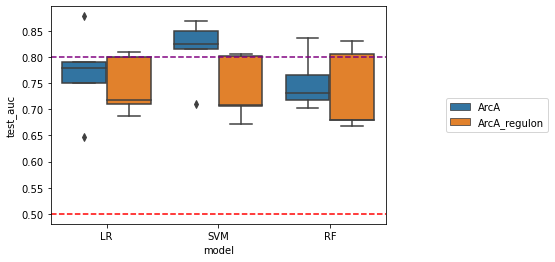

In [31]:
_, ax = plt.subplots()
sns.boxplot(x='model', y='test_auc', data=result_df, hue='im', dodge=True, ax=ax)
plt.legend(loc='right', bbox_to_anchor=(1.5, 0.5))
plt.axhline(y= 0.5, color = 'r', ls = '--')
plt.axhline(y= 0.8, color = 'purple', ls = '--')

In [39]:
hyperopt_models = {
    'LR': {
        'model': LogisticRegression(
            solver='liblinear',
            class_weight='balanced',
            verbose=1
        ),
        'param_dists': {
            'penalty': ['l1', 'l2'],
            'C': np.logspace(-1,2,15),
            'max_iter':np.array([1000])
        }
    }
}

In [40]:
avg_features = pd.read_csv('features_avg.csv')
X = avg_features.iloc[:,1:].values
X = StandardScaler().fit_transform(X)

In [41]:
hyperopt_LR = {}

for y_name, y_labels in y_to_try.items():
    print(y_name)

    random_search_hyperopt = RandomizedSearchCV(
        hyperopt_models['LR']['model'],
        hyperopt_models['LR']['param_dists'],
        n_iter=25,
        scoring='roc_auc',
        n_jobs=4,
        cv=5,
        verbose=1,
        return_train_score=True
    )

    random_search_hyperopt.fit(X_DR,y_labels )
    
    hyperopt_results_df = pd.DataFrame(random_search_hyperopt.cv_results_).sort_values(
        by='mean_test_score',
        ascending=False
    )
    hyperopt_LR[y_name] = hyperopt_results_df

ArcA
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  52 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    3.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]ArcA_regulon
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done 107 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    1.2s finished


[LibLinear]

In [42]:
# combine all the hyperopt results into a DF
dfs_with_ims = []
for y_name, hyperopt_df in hyperopt_LR.items():
    hyperopt_df['im'] = [y_name] * hyperopt_df.shape[0]
    dfs_with_ims.append(hyperopt_df)
    
hyperopt_LR_df = pd.concat(dfs_with_ims, axis=0, ignore_index=True)

In [43]:
hyperopt_LR_df.to_csv('data/ArcA_DR_LRopt.csv')

20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
16.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


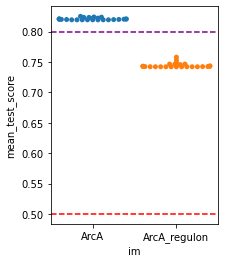

In [47]:
fig = plt.figure(figsize=(3,4))
sns.swarmplot(x='im', y='mean_test_score', data=hyperopt_LR_df)
plt.axhline(y= 0.5, color = 'r', ls = '--')
plt.axhline(y= 0.8, color = 'purple', ls = '--')

In [48]:
hyperopt_LR_old = {}

for y_name, y_labels in y_to_try.items():
    print(y_name)

    random_search_hyperopt = RandomizedSearchCV(
        hyperopt_models['LR']['model'],
        hyperopt_models['LR']['param_dists'],
        n_iter=25,
        scoring='roc_auc',
        n_jobs=4,
        cv=5,
        verbose=1,
        return_train_score=True
    )

    random_search_hyperopt.fit(X,y_labels )
    
    hyperopt_results_df = pd.DataFrame(random_search_hyperopt.cv_results_).sort_values(
        by='mean_test_score',
        ascending=False
    )
    hyperopt_LR_old[y_name] = hyperopt_results_df

# combine all the hyperopt results into a DF
dfs_with_ims = []
for y_name, hyperopt_df in hyperopt_LR_old.items():
    hyperopt_df['im'] = [y_name] * hyperopt_df.shape[0]
    dfs_with_ims.append(hyperopt_df)
    
hyperopt_LR_old_df = pd.concat(dfs_with_ims, axis=0, ignore_index=True)

ArcA
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   35.2s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  2.2min finished


[LibLinear]ArcA_regulon
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   39.4s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.6min finished


[LibLinear]

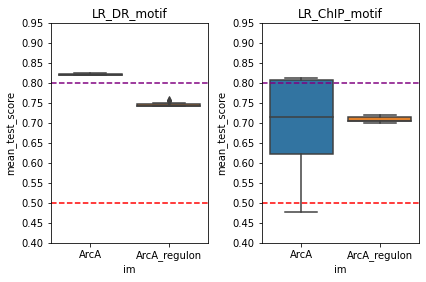

In [49]:
fig,axs = plt.subplots(1,2,figsize=(6,4))
axs[0]=sns.boxplot(x='im', y='mean_test_score', data=hyperopt_LR_df,ax=axs[0])
axs[0].axhline(y= 0.5, color = 'r', ls = '--')
axs[0].axhline(y= 0.8, color = 'purple', ls = '--')
axs[0].set_title('LR_DR_motif')

axs[1]=sns.boxplot(x='im', y='mean_test_score', data=hyperopt_LR_old_df,ax=axs[1])
axs[1].axhline(y= 0.5, color = 'r', ls = '--')
axs[1].axhline(y= 0.8, color = 'purple', ls = '--')
axs[1].set_title('LR_ChIP_motif')
for ax in axs:
    ax.set_yticks(np.arange(0.4,1,0.05))
    ax.set_xticks( np.array( [0,1]) )
fig.tight_layout(pad=1.0)


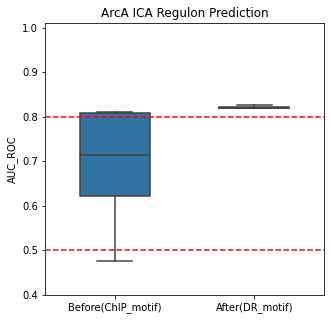

In [68]:
before_score = list(hyperopt_LR_old_df[hyperopt_LR_old_df['im']=='ArcA']['mean_test_score'])
after_score = list(hyperopt_LR_df[hyperopt_LR_df['im']=='ArcA']['mean_test_score'])
score_list = before_score+after_score
model_state = ['Before(ChIP_motif)' for i in range(25)] + ['After(DR_motif)' for i in range(25)]
plt.figure(figsize=(5,5))
sns.boxplot(x=model_state,y=score_list,width=0.5)
plt.title("ArcA ICA Regulon Prediction")
plt.ylabel("AUC_ROC")
plt.ylim([0.4,1.01])
plt.axhline(y= 0.5, color = 'r', ls = '--')
plt.axhline(y= 0.8, color = 'r', ls = '--')
plt.savefig('../../thesis_plots/DRvsChIP_ArcA.svg',dpi=150)

In [74]:
hyperopt_LR_df.iloc[0]['params']

{'penalty': 'l1', 'max_iter': 1000, 'C': 0.16378937069540642}

In [77]:
import shap
from sklearn.model_selection import train_test_split
DR_features= list(avg_DR.columns[1:])

[LibLinear]

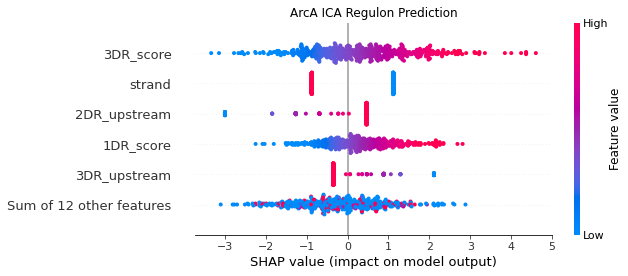

In [79]:
clf_ica = LogisticRegression(solver='liblinear',penalty = 'l1',max_iter=1000,C=0.16378937069540642,class_weight='balanced',verbose=1)
X_ica_fi = pd.DataFrame(
    X_DR, columns= DR_features,
    index=avg_DR.index
)
y_ica_fi = pd.Series( y_to_try['ArcA'] )
X_train, X_test, y_train, y_test = train_test_split( X_ica_fi, y_ica_fi, test_size=0.2, random_state=7)
clf_ica.fit(X_train, y_train)
explainer = shap.Explainer(clf_ica, X_train )
shap_values = explainer(X_test)
plt.title('ArcA ICA Regulon Prediction')
shap.plots.beeswarm(shap_values,max_display=6,show=False)
plt.savefig('../../thesis_plots/ArcA_IM_DR_pred.svg',dpi=150)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 56 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


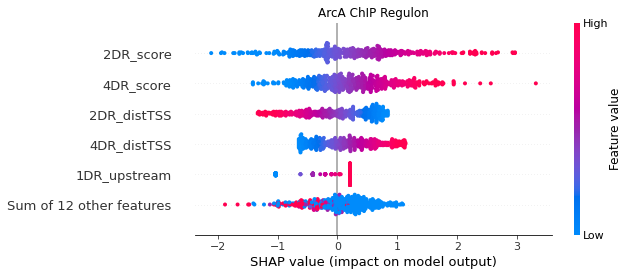

In [38]:
clf_chip = LogisticRegression(solver='saga',penalty = 'l1',max_iter=200,C=0.26,class_weight='balanced',verbose=1)
X_chip_fi = pd.DataFrame(
    X_DR, columns= DR_features,
    index=avg_DR.index
)
y_chip_fi = pd.Series( y_to_try['ArcA_regulon'] )
X_train, X_test, y_train, y_test = train_test_split( X_chip_fi, y_chip_fi, test_size=0.2, random_state=7)
clf_chip.fit(X_train, y_train)
explainer = shap.Explainer(clf_chip, X_train )
shap_values = explainer(X_test)
plt.title('ArcA ChIP Regulon')
shap.plots.beeswarm(shap_values,max_display=6)

## LOOK at important coeffs

In [49]:
ArcA_LR =  LogisticRegression( penalty='l1',C=1.9600000000000002,solver='saga',class_weight='balanced',random_state=42)
ArcA_LR.fit(X_DR,target_labels['ArcA'])

ArcA_LR_weight = [ ( DR_features[i], ArcA_LR.coef_[0][i]) for i in range(len(ArcA_LR.coef_[0]))]
print('ArcA_LR:')
print(sorted(ArcA_LR_weight, key=lambda tup: tup[1],reverse=True)[:10])
print(sorted(ArcA_LR_weight, key=lambda tup: tup[1],reverse=False)[:10])

ArcA_LR:
[('3DR_score', 8.435457491354112), ('2DR_upstream', 7.612473863068168), ('4DR_score', 4.424451138035822), ('1DR_score', 4.243502045684865), ('1DR_upstream', 3.6376775774444083), ('3DR_distTSS', 2.7922907181225547), ('2DR_abovecutoff', 1.3532424787823278), ('4DR_abovecutoff', -0.03434121034771245), ('1DR_distTSS', -0.28076706039346105), ('2DR_score', -0.7944716897094898)]
[('1DR_abovecutoff', -6.642596958529083), ('4DR_upstream', -4.698784356372782), ('strand', -4.561598866655021), ('2DR_distTSS', -3.8846417871234684), ('3DR_upstream', -3.620170702545698), ('4DR_distTSS', -2.165294618348387), ('3DR_abovecutoff', -0.8828118644682832), ('2DR_score', -0.7944716897094898), ('1DR_distTSS', -0.28076706039346105), ('4DR_abovecutoff', -0.03434121034771245)]


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [50]:
ArcAreg_LR =  LogisticRegression( penalty='l1',C=0.26,solver='saga',class_weight='balanced',random_state=42)
ArcAreg_LR.fit(X_DR,ArcA_reg_lab)

ArcAreg_LR_weight = [ ( DR_features[i], ArcAreg_LR.coef_[0][i]) for i in range(len(ArcAreg_LR.coef_[0]))]
print('ArcA regulon LR:')
print(sorted(ArcAreg_LR_weight, key=lambda tup: tup[1],reverse=True)[:10])
print(sorted(ArcAreg_LR_weight, key=lambda tup: tup[1],reverse=False)[:10])

ArcA regulon LR:
[('2DR_score', 0.957783153896663), ('4DR_score', 0.6053738388033473), ('1DR_upstream', 0.4677759972473605), ('4DR_distTSS', 0.37753667602281255), ('3DR_upstream', 0.269949055619016), ('1DR_score', 0.19654827751289128), ('3DR_score', 0.11761733169748334), ('3DR_abovecutoff', 0.07987135391660986), ('1DR_distTSS', 0.00037663449214625575), ('4DR_upstream', -0.02794575313181434)]
[('2DR_abovecutoff', -0.38168633331388896), ('2DR_distTSS', -0.28423607297097264), ('4DR_abovecutoff', -0.2266700276905591), ('2DR_upstream', -0.22574274724725024), ('3DR_distTSS', -0.16550006581730853), ('1DR_abovecutoff', -0.14157584480325225), ('strand', -0.08355183317468982), ('4DR_upstream', -0.02794575313181434), ('1DR_distTSS', 0.00037663449214625575), ('3DR_abovecutoff', 0.07987135391660986)]


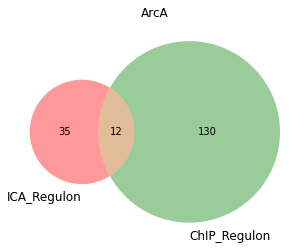

In [80]:
from matplotlib_venn import venn2
venn2([set(IM_genes['ArcA']),set(regulon_genes['ArcA'])],set_labels = ('ICA_Regulon','ChIP_Regulon'))
plt.title('ArcA')
plt.savefig('../../thesis_plots/ArcA_venn.svg',dpi=150)

## check DR scores

In [81]:
def categoryToList( x, category ):
    result = {}
    for i in range(len(x)):
        if category[i] not in result.keys():
            result[ category[i] ] = [ x[i] ]
        else:
            result[ category[i] ].append( x[i] )
    return result

In [82]:
import random
_2DR = []
_3DR = []
_4DR = []
chipmotif = []
ArcA_category = []
for i in range(len(avg_DR['ID'])):
    if avg_DR['ID'][i] in regulon_genes['ArcA']:
        ArcA_category.append('ChIP_Regulon')
        _2DR.append( avg_DR['2DR_score'][i])
        _3DR.append( avg_DR['3DR_score'][i])
        _4DR.append( avg_DR['4DR_score'][i])
        chipmotif.append(avg_features['ArcA score'][i])
        
    if avg_DR['ID'][i] in IM_genes['ArcA']:
        ArcA_category.append('ICA_Regulon')
        _2DR.append( avg_DR['2DR_score'][i])
        _3DR.append( avg_DR['3DR_score'][i])
        _4DR.append( avg_DR['4DR_score'][i])
        chipmotif.append( avg_features['ArcA score'][i] )

for i in range(200):
    rand_index = random.randint(100,2000)
    ArcA_category.append('Random')
    _2DR.append( avg_DR['2DR_score'][rand_index])
    _3DR.append( avg_DR['3DR_score'][rand_index])
    _4DR.append( avg_DR['4DR_score'][rand_index])
    chipmotif.append(avg_features['ArcA score'][rand_index])

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


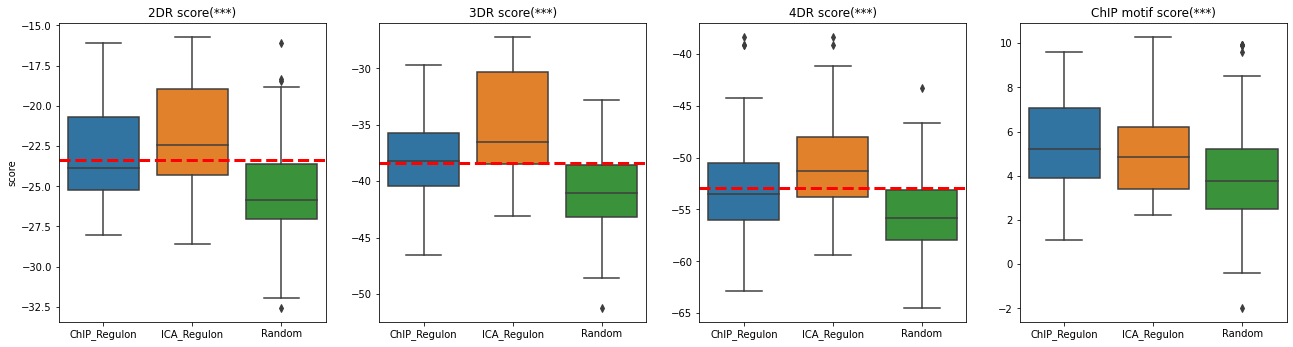

In [84]:
DR_features = [_2DR, _3DR,_4DR,chipmotif ]
titles = ['2DR score','3DR score', '4DR score','ChIP motif score']
fig, axs = plt.subplots(1,4,figsize= (22,5.5))
for i in range(4):
    sns.boxplot( ArcA_category , DR_features[i], ax = axs[i] )
    axs[i].set_title( titles[i]+'(***)')
    if i < 3:
        axs[i].axhline( y = cutoff[i+2], ls = '--', color = 'red',lw=3)
axs[0].set_ylabel('score')
fig.savefig('../../thesis_plots/ArcA_feature_distri.svg',dpi=150)

In [30]:
from scipy.stats import f_oneway
for i in range(4):
    result = categoryToList( DR_features[i] , ArcA_category  )
    p = f_oneway(result['ChIP_Regulon'],result['ICA_Regulon'],result['Random']).pvalue
    print(p)

6.973232188977035e-18
3.5807375306047404e-19
1.2476335304806633e-14
2.6368538921078355e-09
